# Rosely test on RNA-seq data
This notebook contains:
1. Example figure of calculating prior and posterior variance distribution for ascertained *t*-test.
2. Using ascertained *t*-test to compare WT vs. WT replicates of yeast and WT vs. KO.
3. Comparing classical vs. nonclassical monocytes by ascertained *t*-test.

In [1]:
import sys, imp, os, pickle, seaborn
%pylab inline
import scipy.stats as ss
if 'rudolphLab/scripts' not in sys.path: sys.path.insert(0, '/Users/jiangnan/Documents/rudolphLab/scripts')
import rosely
imp.reload(rosely)
from rosely import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib
Rosely version: 1.3.0
import time: 2019-05-16 18:33:56.035535+02:00
Rosely version: 1.3.0
import time: 2019-05-16 18:33:56.039370+02:00


## Fig. 1b
This is a simple example to show the calculation of the prior distribution of variances

In [2]:
cr = CountReads('GSE109177_SafePR50_vs_TMX2PR50-ExpDiff_neurons_.csv.gz', sep=',', igroup=1, 
                group_sample_sep='_')
cr.normalize_data(normalize_by='quantile5', normcutoff=10)
print('Library size:', len(cr.seqids))
groups = list(cr.data.keys())
print('groups:', groups)
cr.nRefs

Library size: 24411
groups: [('Safe', 'PR50-1_S7'), ('Safe', 'PR50-2_S8'), ('Safe', 'PR50-3_S9'), ('TMX2', 'PR50-1_S10'), ('TMX2', 'PR50-2_S11'), ('TMX2', 'PR50-3_S12')]


{('Safe', 'PR50-1_S7'): 732.2247891156622,
 ('Safe', 'PR50-2_S8'): 732.5584775955238,
 ('Safe', 'PR50-3_S9'): 734.7634264290654,
 ('TMX2', 'PR50-1_S10'): 738.9478127858496,
 ('TMX2', 'PR50-2_S11'): 736.8991952319188,
 ('TMX2', 'PR50-3_S12'): 740.1013424711927}

0.428; iterations:0 r0:0.238, re:0.429, a:0.76475 lsq para:[ 0.02527463  0.07221262]
iterations:1 r0:0.141, re:0.356, a:0.63040 lsq para:[-0.02688015 -0.18508232]
iterations:2 r0:0.072, re:0.304, a:0.55599 lsq para:[-0.04468835 -0.2099825 ]
iterations:3 r0:0.032, re:0.274, a:0.51877 lsq para:[-0.05486819 -0.21657524]
iterations:4 r0:0.023, re:0.267, a:0.51047 lsq para:[-0.05769976 -0.22294807]
iterations:5 r0:0.019, re:0.265, a:0.50708 lsq para:[-0.05880589 -0.22459427]
iterations:6 r0:0.018, re:0.264, a:0.50594 lsq para:[-0.05918109 -0.22510371]
iterations:7 r0:0.018, re:0.263, a:0.50585 lsq para:[-0.05920757 -0.22513516]
finetune para: [0.47930538009249252, -0.37547863603519371, 1.9994361172548984]  raw aa: 0.505853619787
total iterations:8 r0:0.018, re:0.263, last a:0.50585
power of p-values: fit: 0.4793, base: 0.7699, final:0.3690
shape (dimensions) of results: (14356, 4)


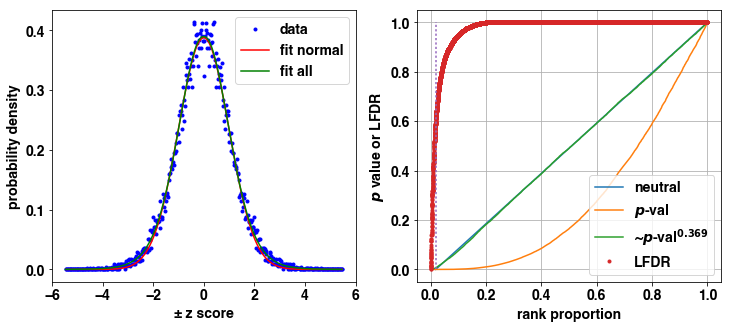

In [3]:
res = count_analysis([
                cr.normdata['Safe'], 
                cr.normdata['TMX2'],
                ], 
                debug=True, weighted=True, transform='log5', minmean=10)

(0, 1.1)

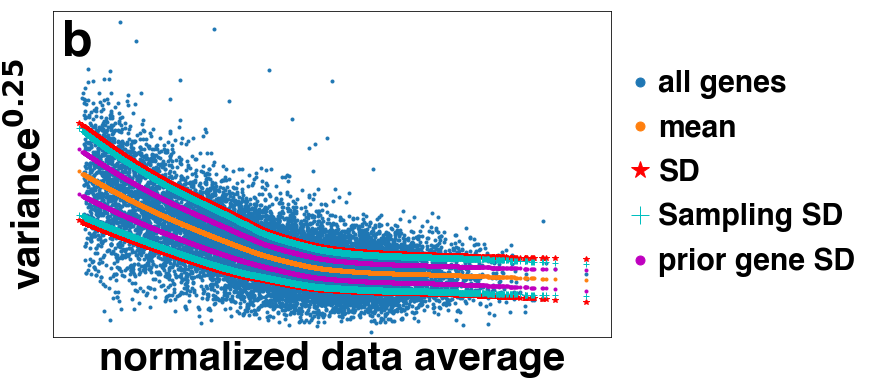

In [4]:
res.plot_variance(0, figsize=(10,6.))
xticks([]); yticks([])
xlabel('normalized data average', fontsize=40)
ylabel('variance$^{{{:.2f}}}$'.format(res.vbs[0]['a']), fontsize=40)
# xlim(2.5, 16)
legend(fontsize=30, loc='center left', bbox_to_anchor=(0.95, 0.5), handletextpad=-.4, 
       frameon=False, markerscale=3.);
text(3.3, 0.95, 'b', fontsize=50)
ylim([0, 1.1])

## Fig. 1c
This shows the calculation of posterior distribution of variance for a gene.

0.01735133636 8.46424556414 0.0123315502226


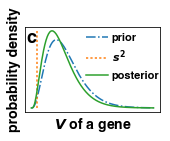

In [5]:
from scipy.special import gammaln, gammainc, gamma, polygamma
def vars2a(n, V, a, y0=0):
    G  = gammaln((n-1)/2)
    Gs = gammaln((n-1)/2+a)
    return (2*V/(n-1))**(2*a) * (exp(gammaln((n-1)/2+2*a)-G) - exp(2*(Gs-G))) - y0
g = 6
vbs = res.vbs[0]
s2 = vbs['Vs'][g]
n  = vbs['n'][g]
EVa = vbs['ElogVs'][g]
EV0 = vbs['EV0s'][g]
VlogV0 = vbs['VlogV0s'][g]
a = vbs['a']
args = (s2, n, EVa, VlogV0, a)
from scipy.integrate import quad
from scipy.optimize import minimize, fsolve
rV = rV = VlogV0 / EV0**(2*a)
n0 = fsolve(vars2a, 2*a**2/rV + 1, args=(EV0, a, VlogV0))[0]
Vmax = ((n0-n-2) + np.sqrt((n0-n-2)**2 + 4*(n0-1)/EV0*(n-1)*s2)) / (2 * (n0-1) / EV0)
print(rV, n0, Vmax)
args = (s2, n, EV0**a, EV0, a, n0, Vmax)
pts = [EV0, s2, Vmax]
M   =  quad(itg.fVls2a, 1e-9, Vmax*100, args=(*args,), points=pts)[0]
figure(figsize=(2.41,1.56))
Vs = linspace(0, Vmax*5.9, 200)
plot(Vs, [itg.fs2lV(V, n0, EV0) for V in Vs], '-.', label='prior')
ymax = itg.fVls2a(Vmax, *args)/M
plot([s2, s2], [0, ymax], ':', label='$s^{2}$')
plot(Vs, [itg.fVls2a(V, *args)/M for V in Vs], label='posterior')
legend(fontsize=11, frameon=False, bbox_to_anchor=[0.38, 0.25], handletextpad=0.3)
xticks([]); yticks([])
xlabel('$V$ of a gene', fontsize=14, fontweight='bold')
ylabel('probability density', fontsize=14, fontweight='bold')
text(-0.23*Vmax, ymax*0.85, 'c', fontsize=18, fontweight='bold')
# ylim([0, 11]);


## Analysis of yeast WT vs. WT

In [6]:
wt = CountReads('WT_raw.tsv.gz',   sep='\t', has_groups=False, header=None)
for i in [21, 22, 25, 28, 34, 36]: del wt.data['all'][i]
wt.normalize_data(normalize_by='quantile5', normcutoff=10)
wt_keys = sorted(wt.data['all'])

ko = CountReads('Snf2_raw.tsv.gz', sep='\t', has_groups=False, header=None)
for i in [6, 13, 25, 35]: del ko.data['all'][i]
ko.normalize_data(normalize_by='quantile5', normcutoff=10)
ko_keys = sorted(ko.data['all'])

In [7]:
wt.data['all'].keys()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64')

In [8]:
wt.data['all'].shape, ko.data.shape

((7126, 48), (7126, 48))

In [9]:
neu_results = {}

## Figure 2a, b

In [10]:
results = {}

In [11]:
idx0=0; idx1 = idx0 + 20
l = len(wt_keys)
for n in range(2, 21):
    if n not in results: 
        results[n] = []
        print('\n' + str(n) + ':', end=' ')
    pops = []; npops = []
    for i in range(len(results[n]), 100):
        keys = array(wt_keys)[random.permutation(l)]
        k0 = keys[idx0:idx0+n]
        k1 = keys[idx1:idx1+n]
        res = count_analysis([wt.subgroup('all', k0),
                              wt.subgroup('all', k1),], 
                                transform='log5', minmean=10, debug=False, with_plot=False, do_SVA=False,
                                pre_neutralize=True, weighted=True, fine_tune=True)
        del res.results; del res.zs; del res.nzs
        res.k0 = k0; res.k1 = k1
        results[n].append(res)
        pops.append(res.ttest_pops[0]); npops.append(res.pop)
        print(i, end=' ')
    print('median pops:', median(pops), 'median npops:', median(npops))



2: 0.853; 0 1.006; 1 1.298; 2 1.079; 3 1.144; 4 1.152; 5 1.312; 6 1.021; 7 1.037; 8 1.142; 9 1.179; 10 0.66; 11 0.555; 12 0.852; 13 0.993; 14 0.899; 15 0.842; 16 0.849; 17 1.204; 18 1.085; 19 0.839; 20 1.263; 21 0.692; 22 1.095; 23 1.336; 24 1.022; 25 0.788; 26 1.208; 27 1.099; 28 1.472; 29 1.335; 30 0.896; 31 1.052; 32 1.237; 33 0.983; 34 1.351; 35 1.138; 36 1.165; 37 0.711; 38 1.013; 39 1.461; 40 1.279; 41 1.151; 42 1.179; 43 1.245; 44 0.753; 45 0.75; 46 1.156; 47 0.971; 48 1.264; 49 1.252; 50 1.154; 51 1.159; 52 0.899; 53 0.861; 54 1.252; 55 1.305; 56 0.436; 57 1.244; 58 1.024; 59 1.314; 60 1.014; 61 1.02; 62 0.993; 63 0.921; 64 1.047; 65 1.062; 66 1.023; 67 0.749; 68 1.191; 69 0.82; 70 1.12; 71 1.069; 72 1.003; 73 1.18; 74 0.666; 75 1.222; 76 0.77; 77 1.235; 78 1.285; 79 1.283; 80 1.089; 81 1.098; 82 1.024; 83 1.566; 84 1.179; 85 1.088; 86 1.173; 87 1.149; 88 1.173; 89 0.91; 90 1.265; 91 1.125; 92 1.569; 93 1.215; 94 1.181; 95 1.032; 96 1.376; 97 1.259; 98 1.245; 99 median pops: 1

In [12]:
nfs = []; nnfs = []
for n in range(2, 21):
    nf = []; nnf = []
    print(n, end=' ')
    for i in range(len(results[n])):
        res = results[n][i]
#         try: res.neutralize_p_values(LFDRthr0=0.5, with_plot=False)
#         except AttributeError: pass
        fdr = false_discovery_rate(list(res.ps.values))
        nf.append (sum(fdr<0.05))
        fdr = false_discovery_rate(list(res.nps.values))
        nnf.append(sum(fdr<0.05))
        res.nf = nf[-1]; res.nnf = nnf[-1]
    nfs.append(nf); nnfs.append(nnf)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

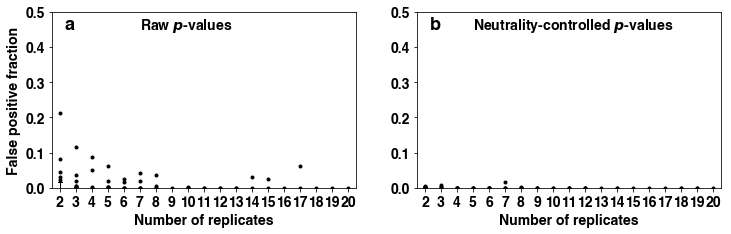

In [13]:
figure(figsize=(12, 11))
for iax, (nnfsi, ym) in enumerate(zip([nfs, nnfs], [0.5, 0.5])):
    ax = subplot(321+iax)
    rfs = []
    for nf in nnfsi: rfs.append(list(array(nf)/7126))
    boxplot(rfs, whis=[5, 95], sym='.k');
    ax.set_xticklabels(range(2, 21));
    ylim([0, ym])
    if iax in [0, 2, 4]: ylabel('False positive fraction', fontweight='bold')
    text(6-iax%2*2, ym*0.9, ['Raw $p$-values', 'Neutrality-controlled $p$-values'][iax%2])
    text(1.3, ym*0.9, 'abcdef'[iax], fontsize=18)
    xlabel('Number of replicates', fontweight='bold')

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

(1.0904982963656051, 1.1044556151344957)

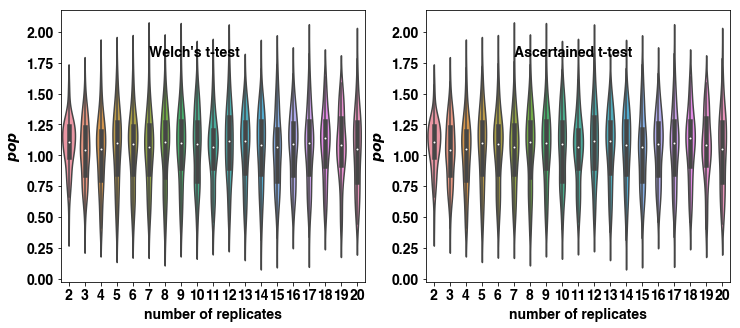

In [14]:
import seaborn
pops = {}; npops = {}
for n in range(2, 21):
    pop = []; npop = []
    print(n, end=' ')
    for i in range(len(results[n])):
        res = results[n][i]
        pop.append(res.ttest_pops[0]); npop.append(res.pop)
    pops[n] = pop; npops[n] = npop
pops = pd.DataFrame(pops); npops = pd.DataFrame(npops)
figure(figsize=(12, 5))
for i, (p, name) in enumerate(zip([pops, npops], ["Welch's t-test", 'Ascertained t-test'])):
    subplot(121+i)
#     seaborn.swarmplot (data=pops, color='k', edgecolor="gray")
    seaborn.violinplot(data=pops)
    xlabel('number of replicates', fontweight='bold')
    ylabel('$pop$')
    text(5, 1.8, name)
pops.median().median(), npops.median().median()

## Figure 2c, d

0.079; iterations:0 r0:0.525, re:0.644, a:0.62203 lsq para:[ 0.04529617  0.14638501]
iterations:1 r0:0.383, re:0.538, a:0.42549 lsq para:[-0.01682302 -0.1767505 ]
iterations:2 r0:0.250, re:0.438, a:0.31544 lsq para:[-0.05087011 -0.18039522]
iterations:3 r0:0.153, re:0.365, a:0.25965 lsq para:[-0.07244942 -0.12953109]
iterations:4 r0:0.092, re:0.319, a:0.23162 lsq para:[-0.09417262 -0.16792001]
iterations:5 r0:0.065, re:0.299, a:0.22042 lsq para:[-0.10251082 -0.1767315 ]
iterations:6 r0:0.052, re:0.289, a:0.21532 lsq para:[-0.1059746  -0.17582244]
iterations:7 r0:0.048, re:0.286, a:0.21375 lsq para:[-0.10688289 -0.17386819]
iterations:8 r0:0.047, re:0.286, a:0.21331 lsq para:[-0.1071291  -0.17325561]
iterations:9 r0:0.047, re:0.285, a:0.21305 lsq para:[-0.10727922 -0.17290908]
finetune para: [0.17945843919001603, -0.36606809237928384, 2.0010252670475324]  raw aa: 0.213049311084
total iterations:10 r0:0.047, re:0.285, last a:0.21305
power of p-values: fit: 0.1795, base: 0.2999, final:0.0

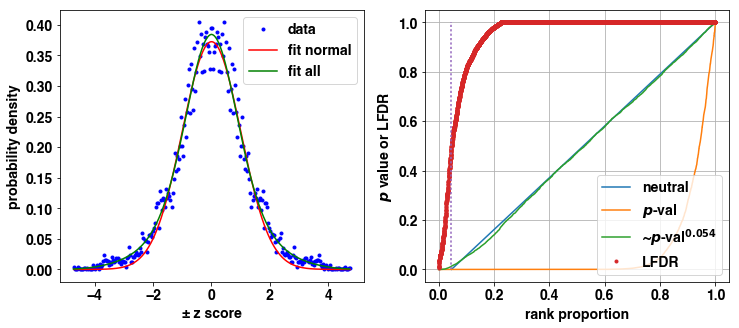

In [15]:
yeast = count_analysis([wt.subgroup('all', wt_keys),
                        ko.subgroup('all', ko_keys),],
                        transform='log5', minmean=10, debug=True, with_plot=True, # method='', 
                        LFDRthr0 = 0.5, pre_neutralize=True, weighted=True, fine_tune=True);

233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 233 1.3620946407318115
iterations:0 r0:0.525, re:0.644, a:0.62203 lsq para:[ 0.04529617  0.14638501]
iterations:1 r0:0.383, re:0.538, a:0.42549 lsq para:[-0.01682302 -0.1767505 ]
iterations:2 r0:0.250, re:0.438, a:0.31544 lsq para:[-0.05087011 -0.18039522]
iterations:3 r0:0.153, re:0.365, a:0.25965 lsq para:[-0.07244942 -0.12953109]
iterations:4 r0:0.092, re:0.319, a:0.23162 lsq para:[-0.09417262 -0.16792001]
iterations:5 r0:0.065, re:0.299, a:0.22042 lsq para:[-0.10251082 -0.1767315 ]
iterations:6 r0:0.052, re:0.289, a:0.21532 lsq para:[-0.1059746  -0.17582244]
iterations:7 r0:0.048, re:0.286, a:0.21375 lsq para:[-0.10688289 -0.17386819]
iterations:8 r0:0.047, re:0.286, a:0.21331 lsq para:[-0.1071291  -0.17325561]
iterations:9 r0:0.047, re:0.285, a:0.21305 lsq para:[-0.10727922 -0.17290908]
finetune para: [0.17945843919001603, -0.36606809237928384, 2.0010252670475324]  raw aa: 0.213049311084
total iterations:1

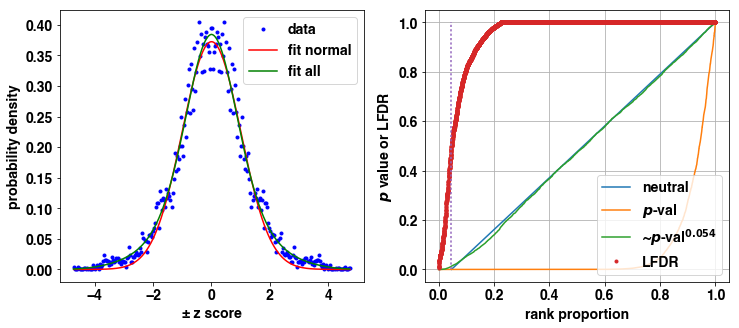

In [16]:
import time
t0 = time.time()
poisreg_method='SLSQP'
for _ in range(20): print(sum(locfdr(ps=yeast.nps, p0s=[0.], with_plot=False, poisreg_method=poisreg_method)<0.4), end=' ')
print(time.time() - t0)
yeast.neutralize_p_values(poisreg_method=poisreg_method, fine_tune=True, LFDRthr0=0.5)

In [17]:
sum(yeast.LFDR < 0.4)

233

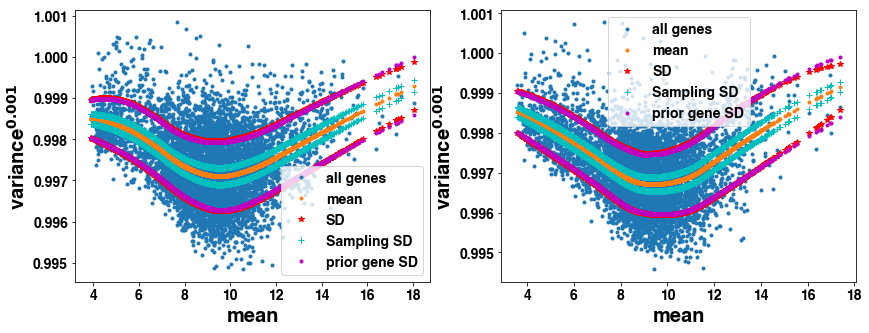

In [18]:
yeast.plot_variance()

## Figure 2e

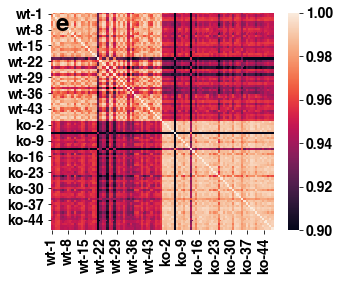

In [19]:
figure(figsize=(5,4))
from copy import deepcopy
wtko = deepcopy(wt)
wtko.data = {}; wtko.normdata = {}
wtko.data['wt'] = wt.data['all']
wtko.normdata['wt'] = wt.normdata['all']
wtko.data['ko'] = ko.data['all']
wtko.normdata['ko'] = ko.normdata['all']
wtko.correlation_heatmap(vmin=0.9)
text(2, 8, 'e', fontsize=24)

## Monocyte study comparing classical vs. nonclassical monocytes

In [20]:
cr = CountReads('SrHt_expressionMatrix.txt.gz', sep='\t', igroup=1, 
                group_sample_sep='ical', has_groups=True)
cr.normalize_data(normalize_by='upper quantile4', normcutoff=10)
print('Library size:', len(cr.seqids))
groups = list(cr.presences.keys())
print('groups:', groups)
# cr.nRefs

Library size: 62069
groups: ['class', 'nonclass']


In [21]:
del cr.normdata['class', '15']
del cr.normdata['nonclass','06']

In [22]:
mkeys = cr.normdata['class'].keys()
mkeys = array(mkeys)[random.permutation(len(mkeys))]

## Figure 2f

0.458; iterations:0 r0:0.174, re:0.381, a:0.80164 lsq para:[ 0.01918824  0.0018236 ]
iterations:1 r0:0.101, re:0.326, a:0.69520 lsq para:[-0.02776783 -0.17772436]
iterations:2 r0:0.065, re:0.299, a:0.65108 lsq para:[-0.03883522 -0.17528573]
iterations:3 r0:0.047, re:0.286, a:0.63102 lsq para:[-0.0428458  -0.15431535]
iterations:4 r0:0.036, re:0.277, a:0.61792 lsq para:[-0.04685806 -0.15605882]
iterations:5 r0:0.032, re:0.274, a:0.61334 lsq para:[-0.04851751 -0.15986775]
iterations:6 r0:0.031, re:0.273, a:0.61239 lsq para:[-0.04885035 -0.16045313]
iterations:7 r0:0.031, re:0.273, a:0.61215 lsq para:[-0.04893747 -0.16065179]
finetune para: [0.58266262807098346, -0.47383501854015647, 1.9991788357730749]  raw aa: 0.612147699437
total iterations:8 r0:0.031, re:0.273, last a:0.61215
power of p-values: fit: 0.5827, base: 0.7015, final:0.4087
shape (dimensions) of results: (12546, 4)


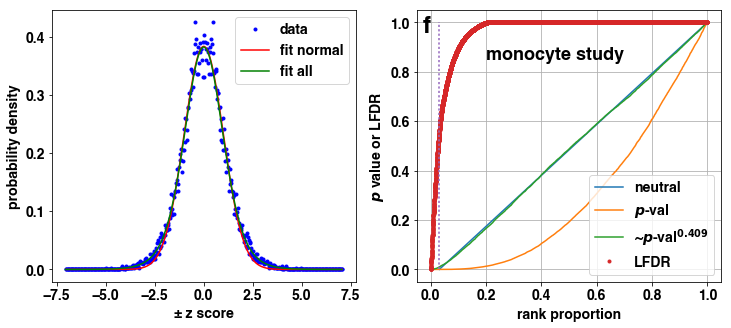

In [23]:
k = mkeys#[:5]
monocyte = count_analysis([cr.subgroup('class', k), 
                           cr.subgroup('nonclass', k)], 
#                      sample_weights=[cr.nRefs_as_weights('class'), cr.nRefs_as_weights('nonclass')],
                     paired=True, pre_neutralize=True, #method='',
                    LFDRthr0=0.5, transform='log5', minmean=10, debug=True, minr0=0.0, weighted=True)
text(-0.03, 0.96, 'f', fontsize=24)
text(0.2, 0.85, 'monocyte study', fontsize=18)

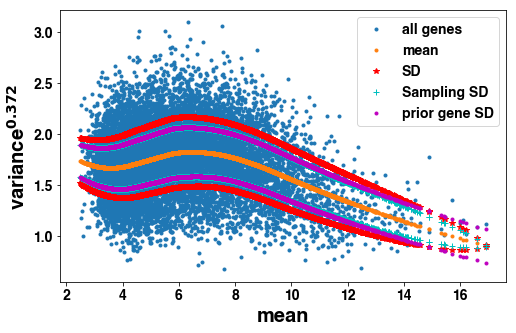

In [24]:
monocyte.plot_variance()

In [25]:
cr.normdata['class'].shape, monocyte.results.shape

((62069, 16), (12546, 4))

In [26]:
sum(monocyte.LFDR < 0.4)

252

In [27]:
monocyte.results.head()

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
ENSG00000137801,0.000002,-7.044575,1.860290e-12,-11.657157
ENSG00000169508,0.000248,-5.743639,9.266339e-09,-7.632273
ENSG00000143546,0.000292,-5.698984,1.205234e-08,-8.006117
ENSG00000203747,0.001619,5.201139,1.980704e-07,7.250377
ENSG00000138061,0.002297,-5.094360,3.499213e-07,-7.723599


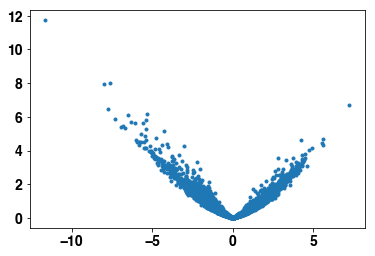

In [28]:
plot(monocyte.results['log2 fold change'], -log10(monocyte.results['Controlled p-value']), '.')

iterations:0 r0:0.525, re:0.644, a:0.62203 lsq para:[ 0.04529617  0.14638501]
iterations:1 r0:0.383, re:0.538, a:0.42549 lsq para:[-0.01682302 -0.1767505 ]
iterations:2 r0:0.250, re:0.438, a:0.31544 lsq para:[-0.05087011 -0.18039522]
iterations:3 r0:0.153, re:0.365, a:0.25965 lsq para:[-0.07244942 -0.12953109]
iterations:4 r0:0.092, re:0.319, a:0.23162 lsq para:[-0.09417262 -0.16792001]
iterations:5 r0:0.065, re:0.299, a:0.22042 lsq para:[-0.10251082 -0.1767315 ]
iterations:6 r0:0.052, re:0.289, a:0.21532 lsq para:[-0.1059746  -0.17582244]
iterations:7 r0:0.048, re:0.286, a:0.21375 lsq para:[-0.10688289 -0.17386819]
iterations:8 r0:0.047, re:0.286, a:0.21331 lsq para:[-0.1071291  -0.17325561]
iterations:9 r0:0.047, re:0.285, a:0.21305 lsq para:[-0.10727922 -0.17290908]
finetune para: [0.17945843919001603, -0.36606809237928384, 2.0010252670475324]  raw aa: 0.213049311084
total iterations:10 r0:0.047, re:0.285, last a:0.21305
power of p-values: fit: 0.1795, base: 0.2999, final:0.0538
ite

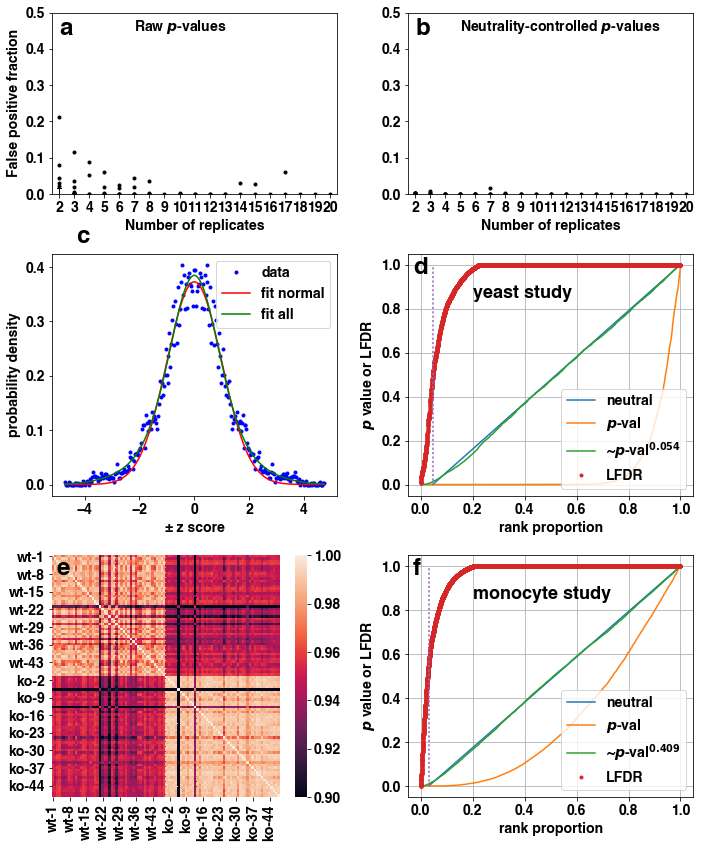

In [29]:
fig, axs = subplots(ncols=2, nrows=3, figsize=(10, 12), 
         gridspec_kw = {'width_ratios':[1,1], 'height_ratios':[3, 4, 4]})
for iax, (nnfsi, ym) in enumerate(zip([nfs, nnfs], [0.5, 0.5])):
    ax = axs[0][iax]
    sca(ax)
    rfs = []
    for nf in nnfsi: rfs.append(list(array(nf)/7126))
    boxplot(rfs, whis=[5, 95], sym='.k');
    ax.set_xticklabels(range(2, 21));
    ylim([0, ym])
    if iax in [0, 2, 4]: ylabel('False positive fraction', fontweight='bold')
    text(6-iax%2*2, ym*0.9, ['Raw $p$-values', 'Neutrality-controlled $p$-values'][iax%2])
    text(1, ym*0.875, 'abcdef'[iax], fontsize=24)
    xlabel('Number of replicates', fontweight='bold')

yeast.neutralize_p_values(new_figure=False, axes=axs[1])
sca(axs[1][0])
text(-4.3, 0.445, 'c', fontsize=24)
sca(axs[1][1])
text(-0.03, 0.96, 'd', fontsize=24)
text(0.2, 0.85, 'yeast study', fontsize=18)

sca(axs[2][0])
wtko.correlation_heatmap(vmin=0.9)
text(2, 8, 'e', fontsize=24)

sca(axs[2][1])
monocyte.neutralize_p_values(new_figure=False, plotLFDR=False, axes=axs[2])
text(-0.03, 0.96, 'f', fontsize=24)
text(0.2, 0.85, 'monocyte study', fontsize=18)
tight_layout()

## Gene Ontology analysis for DEGs in classical vs. nonclassical monocytes
### Load ontology data:

In [30]:
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()
obodag = GODag(obo_fname)
geneid2gos = read_ncbi_gene2go(gene2go, taxids=[9606])

  EXISTS: go-basic.obo
  EXISTS: gene2go
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2018-05-28) 47,248 GO Terms
  19,447 items READ: gene2go


### Convert gene ids

In [31]:
ids = getGeneId(monocyte.results.index, species='human')
monocyte.results['geneid'] = ids['geneid']
monocyte.results['symbol'] = ids['symbol']
rr = monocyte.results.set_index('geneid').dropna()
rr.shape

Querying ensemblgene,symbol 1 ~ 1000 1001 ~ 2000 2001 ~ 3000 3001 ~ 4000 4001 ~ 5000 5001 ~ 6000 6001 ~ 7000 7001 ~ 8000 8001 ~ 9000 9001 ~ 10000 10001 ~ 11000 11001 ~ 12000 12001 ~ 12546 


(10195, 5)

### Use all analyzed genes as population (background)

In [32]:
from goatools.ratio import get_terms
population = rr.index
go2popitems = get_terms("population", population, geneid2gos, obodag, None)
GOs = {}
for go in sorted(go2popitems): 
    if len(go2popitems[go]) >= 5: # Pre-clean GO terms unlikely to be very significant (too few genes in population)
        GOs[go] = {'geneid':go2popitems[go], 'name':obodag[go].name}

### Analyze the enrichment of the top genes with LFDR < 0.4

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0043312,neutrophil degranulation,6.237713e-11,3.300700e-14,38 / 236,383 / 10195,4.29,38,383,"SELL -4.42, CRISPLD2 -5.08, CD93 -6.81, S100A8..."
GO:0005576,extracellular region,2.727384e-08,2.281129e-11,46 / 236,664 / 10195,2.99,46,664,"CRISPLD2 -5.08, S100A8 -8.01, S100A9 -4.74, NR..."
GO:0005886,plasma membrane,5.262152e-08,4.683404e-11,91 / 236,2040 / 10195,1.93,91,2040,"MYO1G 3.03, EPS8 3.48, IL13RA1 -4.38, AAMP 4.1..."
GO:0005887,integral component of plasma membrane,7.870253e-08,7.289269e-11,43 / 236,611 / 10195,3.04,43,611,"SELL -4.42, SELPLG 4.74, LRRC8C -4.07, NRG1 -4..."
GO:0006954,inflammatory response,9.034808e-08,8.485674e-11,24 / 236,203 / 10195,5.11,24,203,"S100A8 -8.01, S100A9 -4.74, THBS1 -11.66, CSF1..."
GO:0035579,specific granule membrane,1.999231e-07,2.042270e-10,15 / 236,74 / 10195,8.76,15,74,"RAB37 3.89, SLC44A2 4.46, CD93 -6.81, GPR84 -4..."
GO:0030593,neutrophil chemotaxis,3.776734e-07,4.146228e-10,11 / 236,35 / 10195,13.58,11,35,"IL1B -4.24, CSF3R -2.89, IL1RN -5.44, S100A8 -..."
GO:0006955,immune response,4.976691e-06,7.737114e-09,20 / 236,176 / 10195,4.91,20,176,"IL1B -4.24, IL1R1 -3.69, HLA-DMA -2.5, IL1RN -..."
GO:0071222,cellular response to lipopolysaccharide,1.020845e-05,1.784908e-08,14 / 236,86 / 10195,7.03,14,86,"IL1B -4.24, CD14 -4.06, IL1RN -5.44, CXCL2 -5...."
GO:0019221,cytokine-mediated signaling pathway,2.691957e-05,5.619513e-08,18 / 236,160 / 10195,4.86,18,160,"IL1B -4.24, IL1R1 -3.69, CSF3R -2.89, IL1RN -5..."


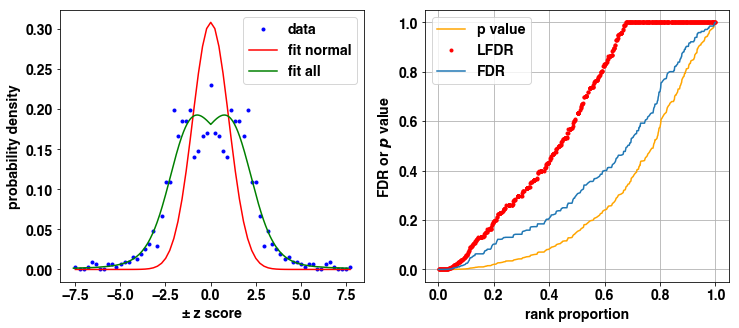

In [33]:
top_genes = rr[rr['LFDR']<0.4].index
goenriched = enrichment_analysis(top_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
goenriched[goenriched['LFDR']<0.4].head(n=10)

In [34]:
goenriched.to_excel('Nonclassical.vs.classical.monocytes.GO.analysis.xlsx')

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0002250,adaptive immune response,0.001930,0.000004,8 / 110,79 / 10195,9.39,8,79,"LILRB1 2.91, CD79B 5.53, PIK3CG 3.38, LILRB2 2..."
GO:0035579,specific granule membrane,0.010051,0.000028,7 / 110,74 / 10195,8.77,7,74,"RAB37 3.89, SLC44A2 4.46, ITGB2 3.32, TSPAN14 ..."
GO:0050776,regulation of immune response,0.011300,0.000033,7 / 110,76 / 10195,8.54,7,76,"FCGR3A 7.25, ITGB2 3.32, LILRB1 2.91, LILRB2 2..."
GO:0030687,"preribosome, large subunit precursor",0.017562,0.000070,4 / 110,18 / 10195,20.60,4,18,"ZNF622 3.91, FTSJ3 3.61, AAMP 4.1, LAS1L 3.61"
GO:0005886,plasma membrane,0.030072,0.000216,39 / 110,2040 / 10195,1.77,39,2040,"SELPLG 4.74, RHOC 4.06, MYO1G 3.03, GPBAR1 3.4..."
GO:0043312,neutrophil degranulation,0.040716,0.000471,13 / 110,383 / 10195,3.15,13,383,"RAB37 3.89, SLC44A2 4.46, MVP 4.19, ITGB2 3.32..."
GO:0008360,regulation of cell shape,0.043144,0.000554,7 / 110,118 / 10195,5.50,7,118,"RHOC 4.06, ITGB2 3.32, EPS8 3.48, CORO1A 4.37,..."
GO:0016020,membrane,0.046342,0.000680,31 / 110,1551 / 10195,1.85,31,1551,"SELPLG 4.74, MYO1G 3.03, CORO1A 4.37, PTPN6 2...."
GO:0042288,MHC class I protein binding,0.053026,0.001012,3 / 110,15 / 10195,18.54,3,15,"LILRB2 2.81, LILRB1 2.91, HLA-E 2.83"
GO:0007166,cell surface receptor signaling pathway,0.056930,0.001252,7 / 110,135 / 10195,4.81,7,135,"BSG 3.69, TSPAN32 3.22, ADGRE5 3.15, LILRB2 2...."


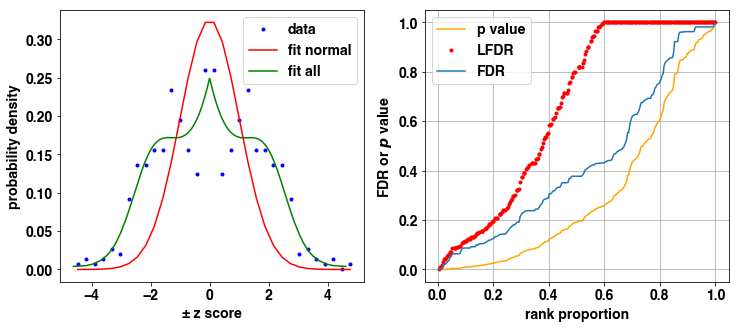

In [35]:
top_up_genes = rr[(rr['LFDR']<0.4) & (rr['log2 fold change']>0)].index
up_goenriched = enrichment_analysis(top_up_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
up_goenriched[up_goenriched['LFDR']<0.6].head(n=10)

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0005576,extracellular region,2.996694e-11,2.556474e-14,36 / 126,664 / 10195,4.39,36,664,"CRISPLD2 -5.08, S100A8 -8.01, S100A9 -4.74, NR..."
GO:0005615,extracellular space,3.683510e-09,5.551116e-12,28 / 126,475 / 10195,4.77,28,475,"CRISPLD2 -5.08, S100A8 -8.01, S100A9 -4.74, NR..."
GO:0043312,neutrophil degranulation,6.718968e-09,1.079745e-11,25 / 126,383 / 10195,5.28,25,383,"SELL -4.42, CRISPLD2 -5.08, CD93 -6.81, S100A8..."
GO:0006954,inflammatory response,4.871325e-08,9.648308e-11,18 / 126,203 / 10195,7.17,18,203,"IL1B -4.24, CD14 -4.06, LYZ -5.41, S100A8 -8.0..."
GO:0005887,integral component of plasma membrane,1.831374e-07,4.186028e-10,29 / 126,611 / 10195,3.84,29,611,"SELL -4.42, LRRC8C -4.07, NRG1 -4.23, THBD -5...."
GO:0030593,neutrophil chemotaxis,2.315119e-07,5.432269e-10,9 / 126,35 / 10195,20.81,9,35,"IL1B -4.24, CSF3R -2.89, IL1RN -5.44, S100A8 -..."
GO:0006955,immune response,2.451616e-06,7.709079e-09,15 / 126,176 / 10195,6.90,15,176,"IL1B -4.24, IL1R1 -3.69, HLA-DMA -2.5, IL1RN -..."
GO:0019221,cytokine-mediated signaling pathway,5.327497e-06,1.878271e-08,14 / 126,160 / 10195,7.08,14,160,"IL1B -4.24, IL1R1 -3.69, CSF3R -2.89, IL1RN -5..."
GO:0030194,positive regulation of blood coagulation,7.736589e-06,2.895483e-08,5 / 126,8 / 10195,50.57,5,8,"HPSE -3.45, S100A9 -4.74, THBS1 -11.66, CD36 -..."
GO:0005886,plasma membrane,1.580967e-05,6.704068e-08,52 / 126,2040 / 10195,2.06,52,2040,"SELL -4.42, CD93 -6.81, S100A8 -8.01, S100A9 -..."


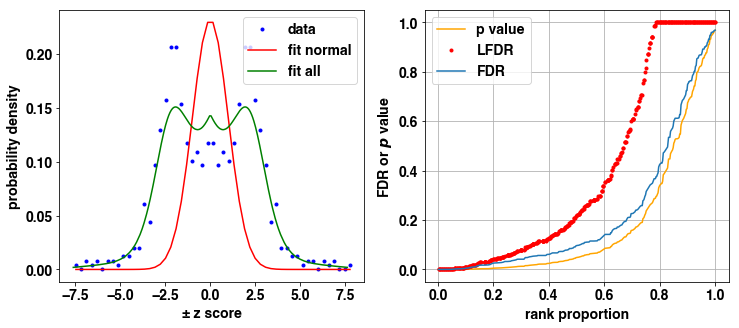

In [36]:
top_down_genes = rr[(rr['LFDR']<0.4) & (rr['log2 fold change']<0)].index
down_goenriched = enrichment_analysis(top_down_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
down_goenriched[down_goenriched['LFDR']<0.6].head(n=10)

In [37]:
documented_up_genes = ['CSFR1', 'Nur77', 'NR4A1', 'BCL2A1A', 'DUSP5', 'HES1', 'OCT2', 'POU2F2', 'TCF7L2', 'CX3CR1', 
                       'CD43', 'SPN', 'CD11a', 'ITGAL', 'CD11c', 'ITGAX', 'CD31', 'PECAM1', 'RRAS', 'CD16', 'Fcgr3',
                      'TNF', 'IL10R', 'IL1B', 'IL6', 'IL1RA', 'TGFBR3', 'LAIR1', 'LTB', 'KLRD1', 'GZMA',
                      'TLR7', 'IFITM1', 'IFITM2', 'IFITM3'] # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4441550/
rr.set_index('symbol').loc[documented_up_genes].dropna()

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
symbol,,,,
NR4A1,0.223355,3.270614,0.001073,3.709771
DUSP5,1.000000,0.242676,0.808257,0.249557
HES1,1.000000,-0.599355,0.548936,-0.538671
POU2F2,0.404258,2.863273,0.004193,2.591674
TCF7L2,0.381597,2.908562,0.003631,3.147851
CX3CR1,0.456983,2.761139,0.005760,3.385252
SPN,0.525224,2.633130,0.008460,2.906715
ITGAL,0.751984,2.197646,0.027974,2.076458
ITGAX,1.000000,-0.857774,0.391017,-0.647069


## Re-analyze the yeast WT vs. WT comparison that had the largest false discoveries

[43 44] [6 9]
1.013; iterations:0 r0:0.035, re:0.276, a:1.07142 lsq para:[ 0.11163416  0.73522341]
finetune para: [1.0401599024150512, 0.00051427837574190868, 1.9999999635904675]  raw aa: 1.03509217344
total iterations:1 r0:0.035, re:0.276, last a:1.07142
power of p-values: fit: 1.0402, base: 1.0000, final:1.0402
shape (dimensions) of results: (5995, 4)


98

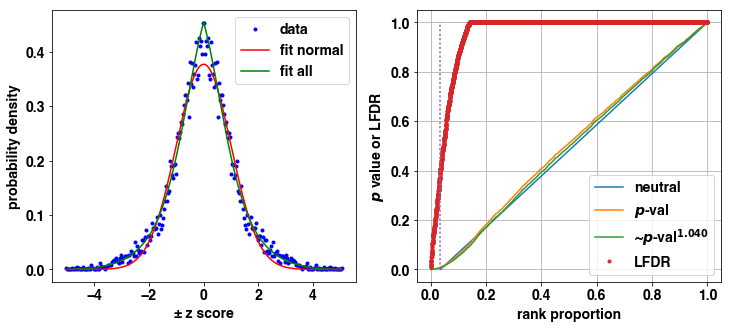

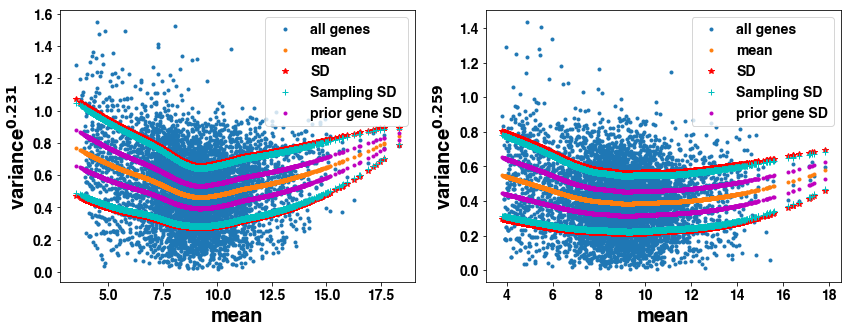

In [38]:
l = len(wt_keys)
n = 2
worst = results[n][sorted([(r.nnf, r.pop, i) for i,r in enumerate(results[n])])[-1][-1]]
print(worst.k0, worst.k1)
res = count_analysis([wt.subgroup('all', worst.k0),
                      wt.subgroup('all', worst.k1),],  #method='',
                        transform='log5', minmean=10, debug=True, with_plot=True, #do_SVA=True, ridge=True, 
                        weighted=True, pre_neutralize=True, fine_tune=True)
res.plot_variance()
sum(res.LFDR < 0.2)

array([43, 44])

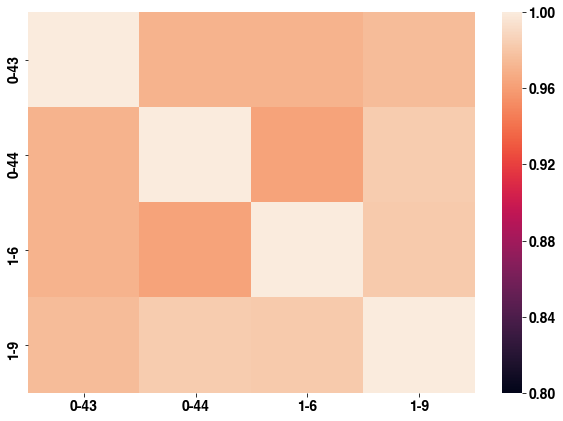

In [39]:
figure(figsize=(10,7))
M = wt.correlation_heatmap(data={'0':wt.subgroup('all', worst.k0), '1':wt.subgroup('all', worst.k1)}, 
                           with_plot=True, by_residual=False);
worst.k0

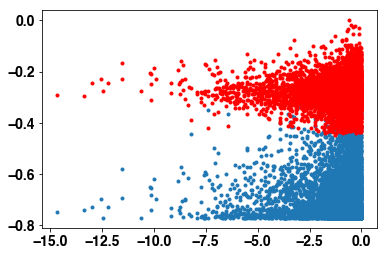

In [40]:
me = pd.DataFrame(wt.subgroup('all', list(keys[idx0:idx0+n])+list(keys[idx1:idx1+n]))).mean(axis=1)
me = log(me.loc[res.LFDR.index])
plot(log(res.nps), log(res.vbs[0]['ElogVs']), '.')
plot(log(res.nps), (res.vbs[0]['x'])/max((res.vbs[0]['x']))-1, 'r.')

In [41]:
# One can do a simple GO analysis at https://david.ncifcrf.gov/tools.jsp to see that the
# DEGs are mostly for ribosome biogenesis, indicating different growth of the replicates. 
for i in res.results[res.results['LFDR']<0.1].index: print(i, end=' ')

ygl184c ybr072w ykl218c ynr034w-a ypl054w ymr189w ydr019c yer091c ymr085w ycr021c ybr147w ybr054w yer150w ykr080w ybr296c ypl012w ypl092w yhr018c ynl015w yhr138c yjl033w ycl030c yhr094c ymr120c yol052c-a yjr109c yjl160c ygl121c yhl036w ybr032w ygl117w ymr049c yal025c 